## 모듈

In [20]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


## GPU사용

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 불러오기

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


## 샘플

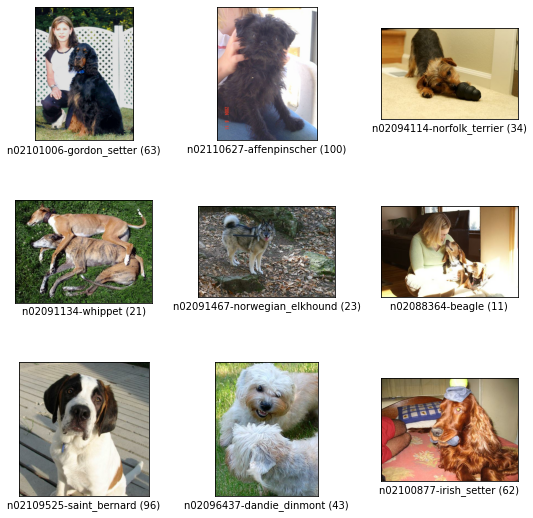

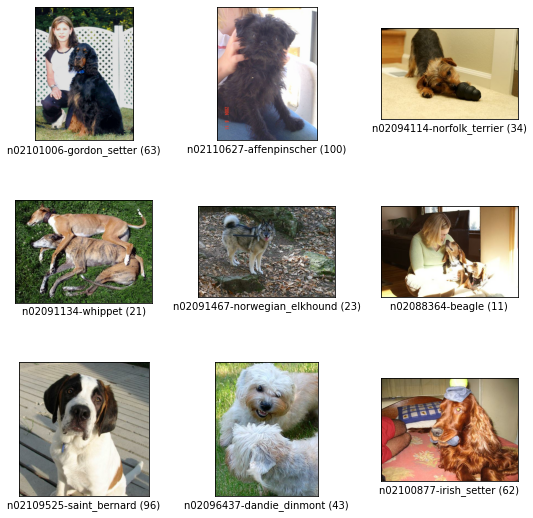

In [23]:
tfds.show_examples(ds_train, ds_info)

## CUTMIX 함수

In [24]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
        
    # get center of box 랜덤 바운딩 박스 영역
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32) 
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box 바운딩 박스의 사이즈
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox 
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size,img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size,num_classes))
    
    # mixed_labels = tf.cast(mixed_labels, tf.int64) # 원핫인코딩 때문에 추가한 코드
    return mixed_imgs, mixed_labels

print('=3')

=3


## MIXUP함수

In [25]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
                
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    # mixed_labels = tf.cast(mixed_labels, tf.int64) # 원핫인코딩 때문에 추가한 코드
    return mixed_imgs, mixed_labels

print('=3')

=3


## 전처리, Aug

In [26]:
def normalize_and_resize_img(image, label):
#     print(f'image : {plt.imshow(image)}')
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])  
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우대칭
    image = tf.image.random_brightness(image, max_delta=0.2)# 밝기
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

print('=3')

=3


## 클래스 종류 

In [27]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

## 모델 정의 4가지 noAug, Aug, cutmix, mixup

In [28]:
# 노 어그멘테이션 모델
noaug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# 어그멘테이션 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# cutmix모델
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# mixup 모델
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


## 학습, 테스트 데이터 분리
- 아무것도 안적용한 학습데이터
- 기본 AUG(flip, brightness)를 적용한 학습데이터
- cutmix를 적용한 학습데이터
- mixup을 적용한 학습데이터 
- 테스트 데이터

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_noaug = apply_normalize_on_dataset(ds_train)# 안 적용
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)# 기본 aug 적용
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)# cutmix 적용
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)# mixup 적용
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print(f'\nds_train_noaug:{ds_train_noaug} \nds_train_aug:{ds_train_aug} \nds_train_cutmix:{ds_train_cutmix} \nds_train_mixup:{ds_train_mixup} \nds_test:{ds_test}')


ds_train_noaug:<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))> 
ds_train_aug:<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))> 
ds_train_cutmix:<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))> 
ds_train_mixup:<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))> 
ds_test:<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


## 훈련

In [30]:
EPOCH = 10

## no Aug 학습

In [31]:
noaug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_noaug = noaug_resnet50.fit(
    ds_train_noaug,  #### 학습데이터 여기를 4가지 적용 해봐야함.
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 96s 119ms/step - loss: 2.2306 - accuracy: 0.4437 - val_loss: 3.5877 - val_accuracy: 0.1760
Epoch 2/10
750/750 [==============================] - 88s 118ms/step - loss: 0.6896 - accuracy: 0.8128 - val_loss: 1.0944 - val_accuracy: 0.6800
Epoch 3/10
750/750 [==============================] - 89s 118ms/step - loss: 0.1833 - accuracy: 0.9671 - val_loss: 0.9674 - val_accuracy: 0.7151
Epoch 4/10
750/750 [==============================] - 88s 118ms/step - loss: 0.0533 - accuracy: 0.9965 - val_loss: 0.9515 - val_accuracy: 0.7280
Epoch 5/10
750/750 [==============================] - 89s 118ms/step - loss: 0.0487 - accuracy: 0.9963 - val_loss: 0.9345 - val_accuracy: 0.7413
Epoch 6/10
750/750 [==============================] - 88s 118ms/step - loss: 0.0171 - accuracy: 0.9996 - val_loss: 0.9246 - val_accuracy: 0.7451
Epoch 7/10
750/750 [==============================] - 93s 124ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.9307 - val_ac

## 기본 Aug 학습

In [32]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,  #### 학습데이터 여기를 4가지 적용 해봐야함.
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 95s 118ms/step - loss: 2.2829 - accuracy: 0.4326 - val_loss: 2.8607 - val_accuracy: 0.2825
Epoch 2/10
750/750 [==============================] - 88s 117ms/step - loss: 0.9380 - accuracy: 0.7334 - val_loss: 1.1256 - val_accuracy: 0.6758
Epoch 3/10
750/750 [==============================] - 88s 117ms/step - loss: 0.4654 - accuracy: 0.8742 - val_loss: 1.1561 - val_accuracy: 0.6708
Epoch 4/10
750/750 [==============================] - 88s 117ms/step - loss: 0.2372 - accuracy: 0.9460 - val_loss: 1.0268 - val_accuracy: 0.6986
Epoch 5/10
750/750 [==============================] - 88s 117ms/step - loss: 0.1279 - accuracy: 0.9780 - val_loss: 1.0373 - val_accuracy: 0.7155
Epoch 6/10
750/750 [==============================] - 88s 117ms/step - loss: 0.0766 - accuracy: 0.9879 - val_loss: 1.0744 - val_accuracy: 0.7137
Epoch 7/10
750/750 [==============================] - 88s 117ms/step - loss: 0.0731 - accuracy: 0.9878 - val_loss: 1.0600 - val_ac

## cutmix학습

In [33]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,  #### 학습데이터 여기를 4가지 적용 해봐야함.
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 98s 122ms/step - loss: 3.8440 - accuracy: 0.2141 - val_loss: 3.3551 - val_accuracy: 0.1981
Epoch 2/10
750/750 [==============================] - 91s 121ms/step - loss: 2.9192 - accuracy: 0.4437 - val_loss: 1.7056 - val_accuracy: 0.5413
Epoch 3/10
750/750 [==============================] - 91s 121ms/step - loss: 2.6225 - accuracy: 0.5362 - val_loss: 1.3425 - val_accuracy: 0.6243
Epoch 4/10
750/750 [==============================] - 91s 122ms/step - loss: 2.4204 - accuracy: 0.6054 - val_loss: 1.2173 - val_accuracy: 0.6583
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 2.2684 - accuracy: 0.6518 - val_loss: 1.2106 - val_accuracy: 0.6790
Epoch 6/10
750/750 [==============================] - 91s 122ms/step - loss: 2.1383 - accuracy: 0.6889 - val_loss: 1.3381 - val_accuracy: 0.6472
Epoch 7/10
750/750 [==============================] - 95s 127ms/step - loss: 2.0534 - accuracy: 0.7193 - val_loss: 1.5133 - val_ac

## mixup학습

In [34]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,  #### 학습데이터 여기를 4가지 적용 해봐야함.
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 99s 123ms/step - loss: 3.7437 - accuracy: 0.2370 - val_loss: 4.0181 - val_accuracy: 0.1171
Epoch 2/10
750/750 [==============================] - 91s 121ms/step - loss: 2.8580 - accuracy: 0.4864 - val_loss: 1.4752 - val_accuracy: 0.5932
Epoch 3/10
750/750 [==============================] - 91s 121ms/step - loss: 2.5787 - accuracy: 0.5871 - val_loss: 1.3374 - val_accuracy: 0.6388
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 2.3819 - accuracy: 0.6544 - val_loss: 1.2780 - val_accuracy: 0.6449
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 2.2477 - accuracy: 0.7097 - val_loss: 1.3211 - val_accuracy: 0.6369
Epoch 6/10
750/750 [==============================] - 91s 122ms/step - loss: 2.1753 - accuracy: 0.7372 - val_loss: 1.3004 - val_accuracy: 0.6451
Epoch 7/10
750/750 [==============================] - 91s 122ms/step - loss: 2.0529 - accuracy: 0.7797 - val_loss: 1.2131 - val_ac

## 4가지 모델 시각화

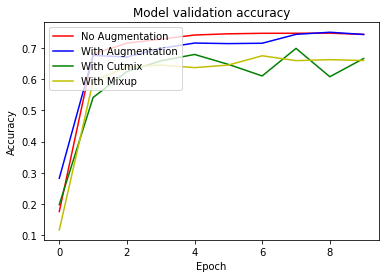

In [38]:
plt.plot(history_resnet50_noaug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup'], loc='upper left')
plt.show()

## 확대 시각화

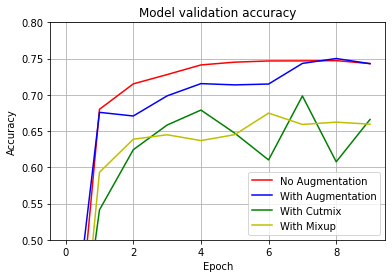

In [39]:
plt.plot(history_resnet50_noaug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup'], loc='lower right')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

평가문항	상세기준
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  YES!

2. CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
  - 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? YES!

3. 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음.

  - 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? 

    - Augmentation은 오버피팅방지용임. 정확도와는 무관!!!

4. 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. YES!!

In [42]:
# else는 if 하나에만 관여한다.
a=0
if a==0:
  print('a')
if a==1:
  print('b')
else:
  print('c')

a
c
